# TP1 Modèles de langue: exploration de la tokenization et des embeddings

Dans ce TP nous allons explorer un peu la tokenization d'un modèle de langue, en regardant par exemple la correspondance avec les mots d'un dictionnaire classique.

Puis nous allons étudier l'espace de représentation des embeddings associés aux sous-tokens dans un modèle, et tester si les mots proches en sens sont tokenisés avec des sous-tokens proches.

Enfin, nous visualiserons les correspondances entre 2 langues dans l'espace des représentations créé par un modèle multilingue.

In [ ]:
%%capture
# pour faire de la réduction de dimension de l'espace des embeddings
!pip install umap-learn
# dictionnaire multilingue de traductions mot -> mot
!pip install word2word

In [ ]:
# lexique de mots anglais
!wget https://www.irit.fr/~Philippe.Muller/lexicon.txt.gz
!gunzip lexicon.txt.gz

--2025-09-17 14:05:07--  https://www.irit.fr/~Philippe.Muller/lexicon.txt.gz
Resolving www.irit.fr (www.irit.fr)... 141.115.28.2
Connecting to www.irit.fr (www.irit.fr)|141.115.28.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 372728 (364K) [application/x-gzip]
Saving to: ‘lexicon.txt.gz’

lexicon.txt.gz      100%[===================>] 363.99K   718KB/s    in 0.5s    

2025-09-17 14:05:08 (718 KB/s) - ‘lexicon.txt.gz’ saved [372728/372728]



In [ ]:
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pds

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForMaskedLM
import torch
import pandas as pds
import itertools
import gzip

In [ ]:
import word2word

In [ ]:
# on peut essayer différents modèles, mais seul le dernier est multilingue
#MODEL = "bert-base-uncased"
#MODEL = "roberta-base"
MODEL = "bert-base-multilingual-cased"
cpt = {}

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [ ]:
lexicon = set([x.strip() for x in open("lexicon.txt").readlines()])

# Tokenization

- Appliquer le tokenizer associé à des modèles listés plus haut, à tous les mots du lexique anglais, pour récupérer tous les sous-mots utilisés, et faites un comptage du nombre de mots dans lequel chacun apparait.

Que peut-on dire des plus fréquents ?

(conseils: le faire en un seul appel au tokenizer, pas mot à mot; le comptage peut être fait avec le module collections.Counter de python ou bien pandas)

- A quoi correspondent les symboles spéciaux ?

- Créer un dictionnaire qui associe à chaque mot du lexique la liste des sous-tokens qui le composent
(pour être plus efficace, vous pouvez prendre la liste des sous-mots générés à la 1er question; la 2e question est important aussi !)


# Analyse des embeddings de base préentrainés

Charger un des modèles avec la library transformers avec AutoModelForMaskedLM.

Affichez la structure du modèle pour trouvez la matrice d'embeddings des sous tokens du vocabulaire du modèle.

Quelle est sa taille ? Quelle est la dimension des embeddings ?

In [ ]:
model = AutoModelForMaskedLM.from_pretrained(MODEL)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Similarité de mots

- Testez la similarité de deux sous-tokens qui sont aussi des mots (pour faire plus simple), en utilisant la similarité cosinus (dans torch.nn) entre leur vecteur d'embedding de base.

- Testez aussi quelques mots de langues différentes avec le modèle multilingue
(par exemple chien/dog)

# Visualisation

On va maintenant faire une réduction de dimension pour essayer de voir des régularités de l'espace des embeddings ("espace latent")

Nous utiliserons la méthode UMAP qui est bien adaptée en grande dimension, avec les paramètres suivants

In [ ]:
# vous pouvez faire varier les 2 premiers pour voir, mais attention le calcul est assez long
params={"n_neighbors":15,
        "min_dist":0.1,
        "n_components":2,
        "metric":"euclidean",
       }

On peut appeler la méthode comme suit.

In [ ]:
reducer = umap.UMAP(random_state=42,**params)
# méthode alternative plus lente
# reducer = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3)
#-------
# attention meme umap va prendre quelques minutes ! (~5mn dans colab)
%time  redux = reducer.fit_transform(initial_embed_matrix.detach().numpy())

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


CPU times: user 5min 17s, sys: 5.96 s, total: 5min 23s
Wall time: 5min 22s


redux est maintenant une nouvelle représentation des sous-tokens dans un espace en 2 dimensions. Vérifiez sa taille.
On va visualiser seulement les sous-tokens les plus courants pour ne pas trop surcharger.
Récupérer les indices des N=1000 (par exemple) sous-tokens les plus courants à partir du comptage fait plus haut.


(1000, 2)


/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 52272 (\N{HANGUL SYLLABLE CAL}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 2613 (\N{GURMUKHI LETTER VA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Matplotlib currently does not support Gurmukhi natively.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 2631 (\N{GURMUKHI VOWEL SIGN EE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 2562 (\N{GURMUKHI SIGN BINDI}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 25209 (\N{CJK UNIFIED IDEOGRAPH-6279}) missing fro

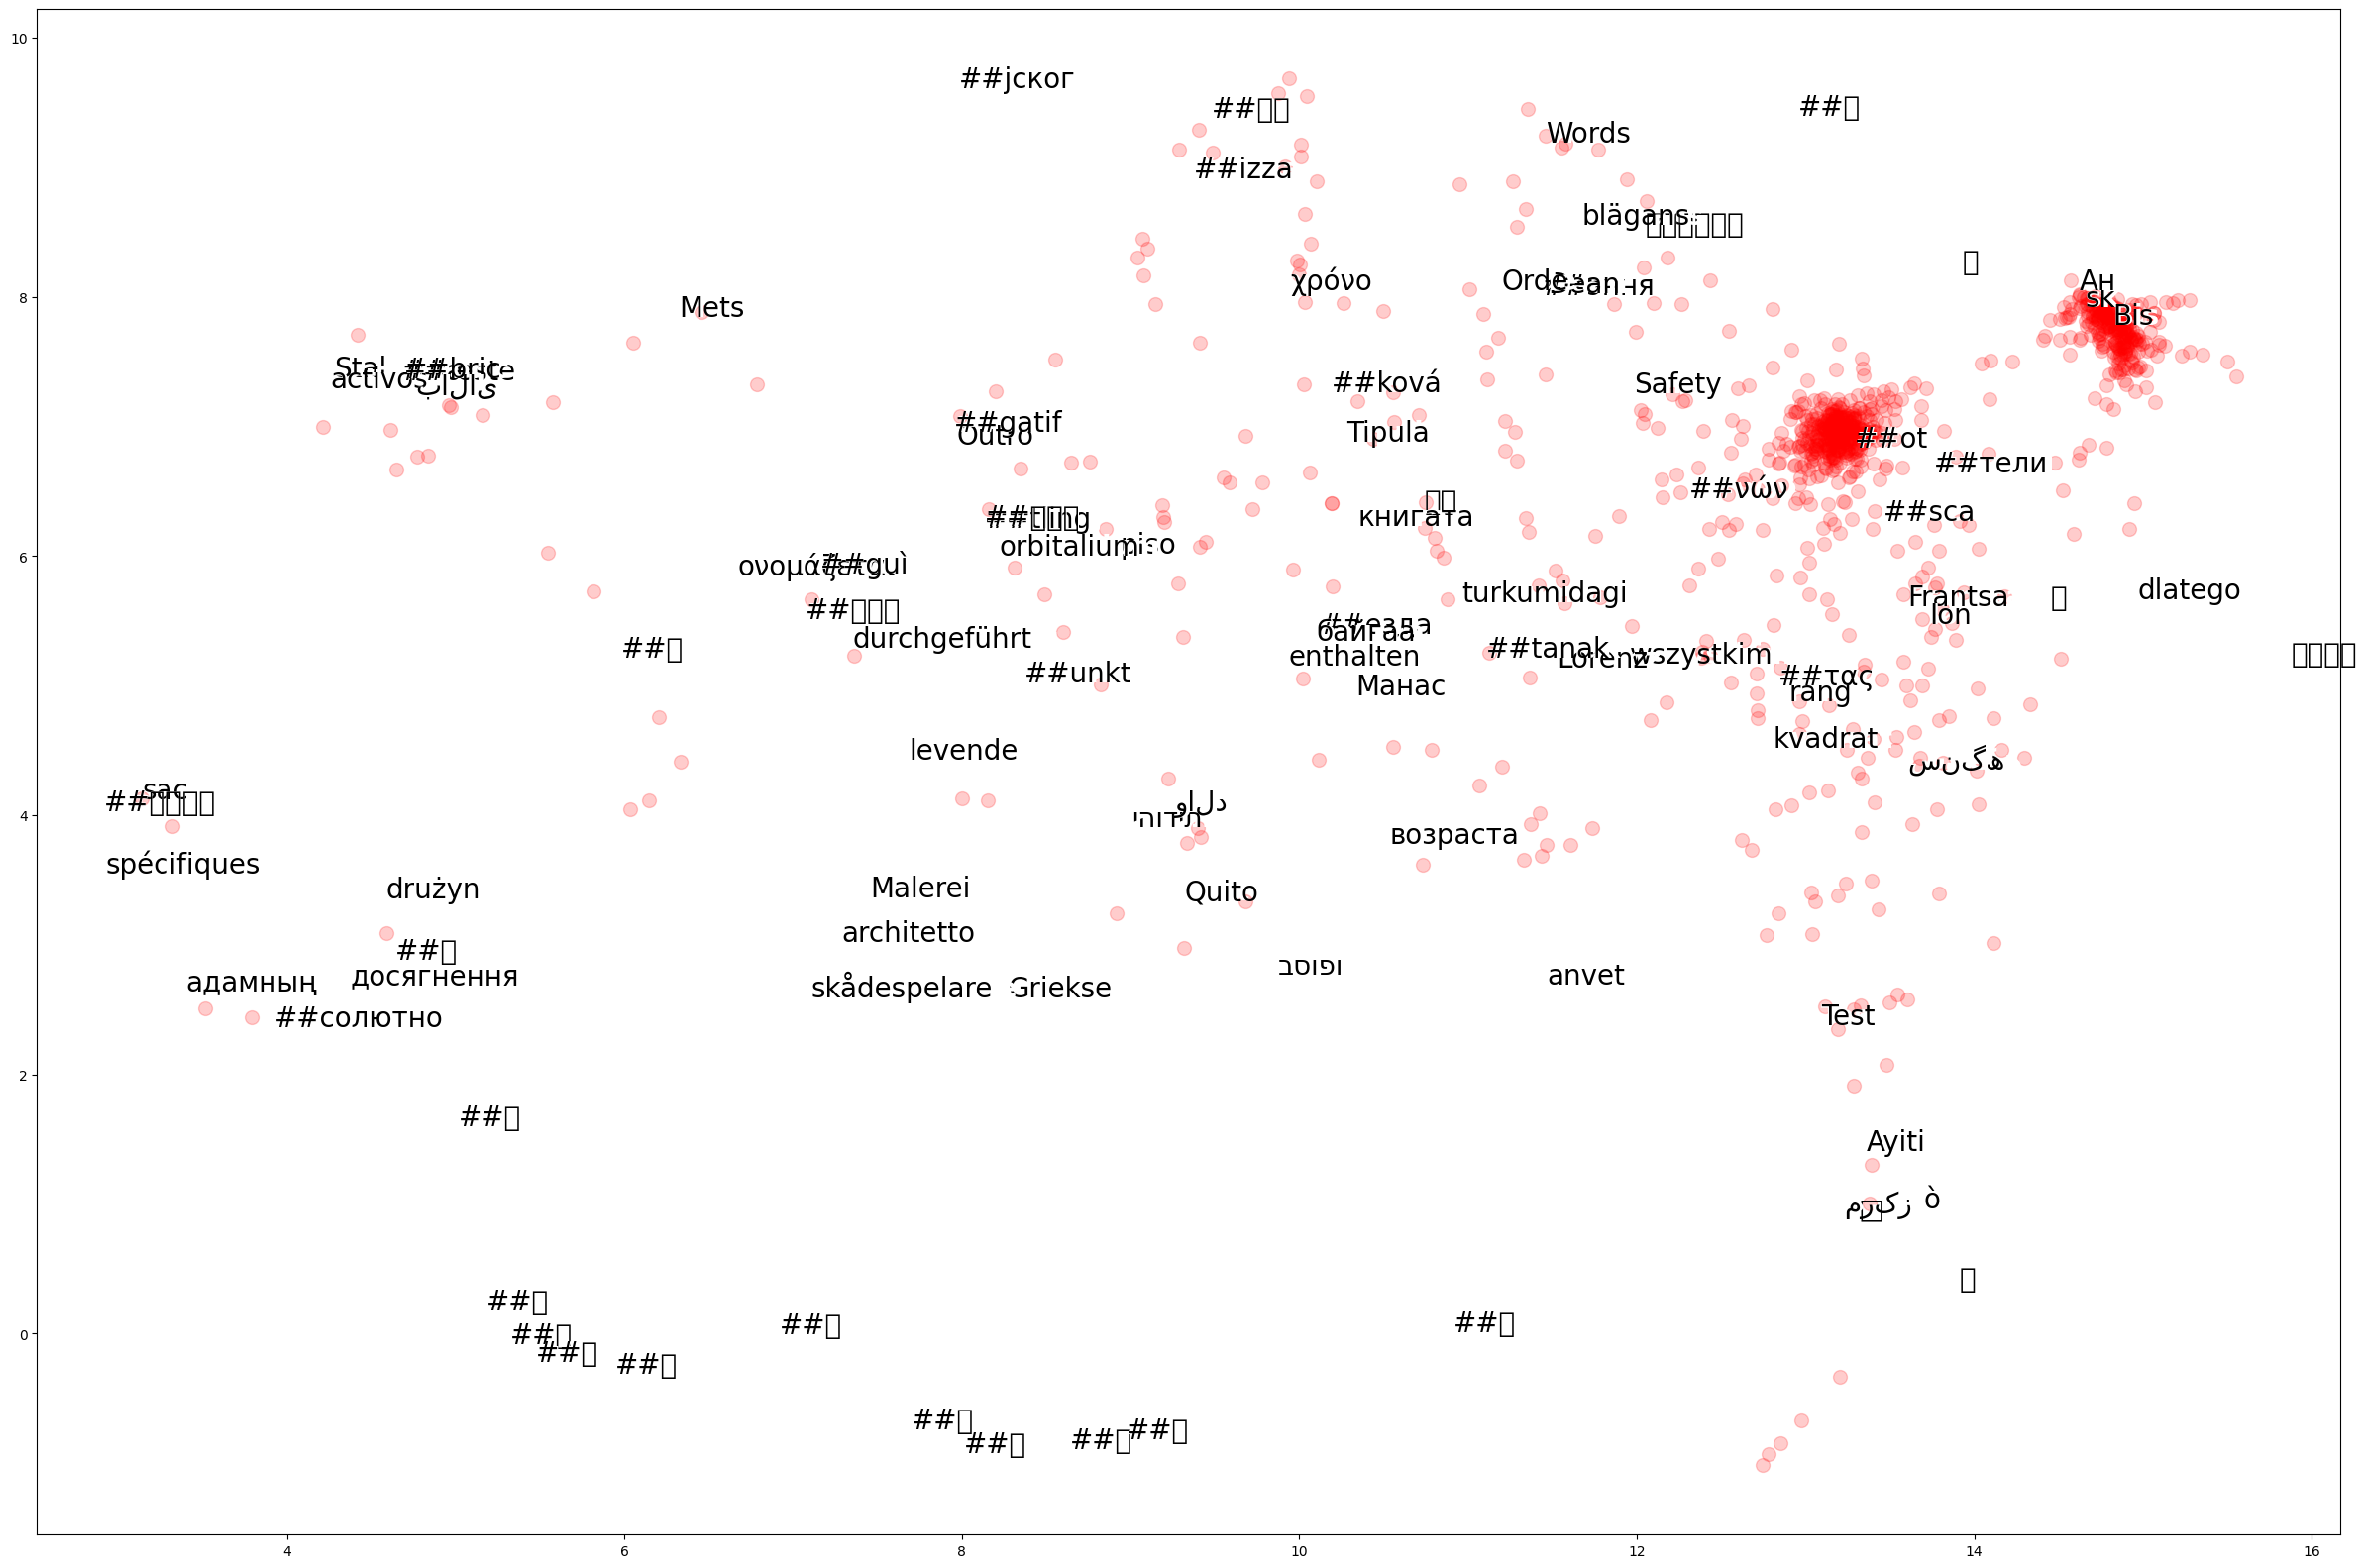

In [ ]:
from numpy import random
# ce code affiche la projection en 2D, avec la chaine correspondant à chaque sous-token pour un échantillon
# au hasard
# remplacez l'échantillon par les N sous-tokens les plus courants et observez la différence
fig, ax = plt.subplots(figsize=(30, 20))
#plt.scatter(redux[:, 0], redux[:, 1],alpha=0.1)
top100_pt = redux[np.array(top100_id)]
print(top100_pt.shape)
plt.scatter(top100_pt[:,0],top100_pt[:,1],s=100,c="r",alpha=0.2)
#
sample = random.randint(redux.shape[0],size=100)
for idx in list(sample.data):
    ax.annotate(tokenizer.convert_ids_to_tokens(idx),redux[idx],size=20,c="w",weight="bold")
    ax.annotate(tokenizer.convert_ids_to_tokens(idx),redux[idx],size=20)

# Traduction / mapping entre langues

On va charger un dictionnaire bilingue avec la librairie word2word:

In [ ]:
en2fr = word2word.Word2word("en", "fr")

Pour simplifier on va juste regarder la première traduction proposée pour chaque mot anglais qui est un sous-token dans un modèle multilingue comme mBert.

- Vérifiez le contenu du mapping en2fr, prenez un exemple, et calculez le mapping sous-token anglais -> mot français qui est aussi un sous-token du modèle.
Cela nous donnera un ensemble de mot en/fr qui sont dans le vocabulaire des sous-tokens du modèle.

- On va maintenant regarder pour chaque token "anglais" quel est le token "français" le plus proche: calculez cette association avec la similarité cosinus. On peut sauver le tout dans une table pandas.

- regardez la distribution des similarités. regardez les valeurs à 1, et les valeurs élevées mais <1 (par exemple 0.5-.99)

In [ ]:
# contenu du dictionnaire ?
en2fr.__dict__.keys()

dict_keys(['lang1', 'lang2', 'word2x', 'y2word', 'x2ys', 'summary'])

In [ ]:
# test
en2fr('militia')

['milice', 'miliciens', 'Milice', 'armée', 'guerre']

## Analyse

- que peut-on dire des mots les plus proches ?

- si on veut vérifier que les traductions sont toujours proches on va reprendre la projection de l'espace latent en affichant les traductions et la distance mot-traduction dans la figure en utilisant le code suivant (doit générer la figure exemple ou approchant).

- Que concluez vous sur les embeddings du modèle considéré ?

In [ ]:
# visualisation interactive des tokens
import plotly.express as px
# remplacez par ce que vous avez trouvé comme ensemble de mots qui sont des mots anglais
# et des mots français.
# le code suppose que target a
#  - des champs x et y pour les coordonnées de la projection umap
#  - un champ pour dire dans quel langue le token est un mot
#  optionnellement: (la figure peut se faire sans mais c'est moins intéressant)
#  - un champ tok qui donne la chaine du token
#  - un champ french_word pour la traduction du mot en français (si mot pas français)
#  - un champ distance pour la distance cosinus entre le mot et sa traduction
target = "?"

fig = px.scatter(both, x="x", y="y", color="lang",
                 color_discrete_sequence=['black','red'],
                 hover_name='tok',hover_data=["french_word","distance"],
                 width=1200, height=800,
                 template="seaborn")

fig.update_traces(opacity=.1)
fig.show()


# Question Bonus:

refaire la visualisation de l'espace latent avec la projection finale des mots anglais passés dans le modèle *encodeur*

vous pouvez utiliser les fonctions suivantes qui appelent un modèle encodeur sur une liste de mot et récupérent les activations de chaque couche moyennées sur les sous-tokens d'un mot

vous pouvez le faire avec un échantillon de mots au hasard

In [ ]:
# appel du modèle + recup toutes les couches visées en les sommant
def get_hidden_states(encoded, token_ids_word, model, layers):
    # inference
    with torch.no_grad():
        output = model(**encoded,output_hidden_states=True)
    # get all hidden states
    states = output.hidden_states
    # stack and sum layers
    output = torch.stack([states[i] for i in layers]).sum(0).squeeze()
    # subset for tokens that make up the word, averaged on subtokens
    word_tokens_output = output[token_ids_word]
    return word_tokens_output.mean(dim=0)

# encode the sentence, get vector representing the word at index idx for given layers
def get_word_vector(sent, idx, tokenizer, model, layers, device):
    # tokenize the input sentence and sending to device
    encoded = tokenizer.encode_plus(sent, add_special_tokens=True, return_tensors="pt").to(device)
    # get all token idxs that make up the target word
    token_ids_word = np.where(np.array(encoded.word_ids()) == idx)
    # get all hidden states
    return get_hidden_states(encoded, token_ids_word, model, layers)

# main function to get encoding vector of given word occuring in a given sentence
# layers = set of layers to average for the representation
# if want only the last one call with layers = [-1]
def get_embedding(model, tokenizer, sent, word, device, layers=None):
    # using last four layers by default
    layers = [-4, -3, -2, -1] if layers is None else layers
    # get idx for the word
    idx = sent.split(" ").index(word)
    # get word embedding
    word_embedding = get_word_vector(sent, idx, tokenizer, model, layers, device)
    return word_embedding